In [27]:
"""
MOVIE GENRE PREDICTION PIPELINE
---------------------------------
Works for:
Train columns : ID, TITLE, GENRE, DESCRIPTION
Test columns  : ID, TITLE, DESCRIPTION

Steps:
1. Load train & test files
2. Clean text
3. TF-IDF vectorization
4. Train NB, Logistic Regression, LinearSVC
5. Select best model using F1 score
6. Retrain on full train data
7. Predict test GENRE
8. Export final Excel output
"""

import pandas as pd
import numpy as np
import re
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# 1. LOAD DATA
# -------------------------------
train_path = "C:\Users\Saurabh\Trim 4\ML\Codsoft\Genre Classification Dataset\train_data.txt"
test_path  = "C:\Users\Saurabh\Trim 4\ML\Codsoft\Genre Classification Dataset\test_data.xlxs"

train_df = pd.read_excel(train_path)
test_df  = pd.read_excel(test_path)

print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)


Train Shape: (54214, 4)
Test Shape: (54200, 3)


In [28]:
#2. TEXT CLEANING FUNCTION
# -------------------------------
STOPWORDS = {
    'the','and','is','in','it','of','to','a','an','that','this','with','for','as',
    'on','at','by','from','be','are','was','were','or','but','not','they','their',
    'have','has','had','he','she','you','i','we','us','them','its'
}

def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = [w for w in text.split() if w not in STOPWORDS and len(w) > 2]
    return " ".join(tokens)

# Apply cleaning
train_df["clean_text"] = train_df["DESCRIPTION"].astype(str).apply(clean_text)
test_df["clean_text"]  = test_df["DESCRIPTION"].astype(str).apply(clean_text)


In [29]:
# -------------------------------
# 3. LABEL ENCODING GENRES
# -------------------------------
le = LabelEncoder()
train_df["GENRE"] = train_df["GENRE"].fillna("Unknown")
y = le.fit_transform(train_df["GENRE"])

print("Detected GENRE classes:", list(le.classes_))


Detected GENRE classes: [' action ', ' adult ', ' adventure ', ' animation ', ' biography ', ' comedy ', ' crime ', ' documentary ', ' drama ', ' family ', ' fantasy ', ' game-show ', ' history ', ' horror ', ' music ', ' musical ', ' mystery ', ' news ', ' reality-tv ', ' romance ', ' sci-fi ', ' short ', ' sport ', ' talk-show ', ' thriller ', ' war ', ' western ']


In [30]:
# -------------------------------
# 4. TRAIN / VALIDATION SPLIT
# -------------------------------
X_train_text, X_val_text, y_train, y_val = train_test_split(
    train_df["clean_text"], y, test_size=0.2, random_state=42, stratify=y
)

In [36]:
# -------------------------------
# 5. TF-IDF VECTORIZATION
# -------------------------------
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

X_train = tfidf.fit_transform(X_train_text)
X_val = tfidf.transform(X_val_text)
X_test = tfidf.transform(test_df["clean_text"])

print("TF-IDF Shapes (train/val/test):", X_train.shape, X_val.shape, X_test.shape)


TF-IDF Shapes (train/val/test): (43371, 10000) (10843, 10000) (54200, 10000)


In [38]:
# -------------------------------
# 6. TRAIN MULTIPLE MODELS
# -------------------------------
results = {}
models = {}

# Model A: Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
pred_nb = nb.predict(X_val)
results["MultinomialNB"] = f1_score(y_val, pred_nb, average="weighted")
models["MultinomialNB"] = nb

# Model B: Logistic Regression
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_val)
results["LogisticRegression"] = f1_score(y_val, pred_lr, average="weighted")
models["LogisticRegression"] = lr

# Model C: Linear SVC
svc = LinearSVC(max_iter=5000)
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_val)
results["LinearSVC"] = f1_score(y_val, pred_svc, average="weighted")
models["LinearSVC"] = svc

print("\nValidation F1 scores:")
print(results)


Validation F1 scores:
{'MultinomialNB': 0.42255496150375343, 'LogisticRegression': 0.5413189502279404, 'LinearSVC': 0.5459093914316894}


In [40]:
# -------------------------------
# 7. PICK BEST MODEL
# -------------------------------
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

print("\nBest model selected:", best_model_name)


Best model selected: LinearSVC


In [42]:
# -------------------------------
# 8. RETRAIN BEST MODEL ON FULL TRAIN DATA
# -------------------------------
X_full = tfidf.fit_transform(train_df["clean_text"])
y_full = le.transform(train_df["GENRE"])

final_model = models[best_model_name].__class__()   # new instance
if best_model_name == "LogisticRegression":
    final_model = LogisticRegression(max_iter=2000)
elif best_model_name == "LinearSVC":
    final_model = LinearSVC(max_iter=5000)
elif best_model_name == "MultinomialNB":
    final_model = MultinomialNB()

final_model.fit(X_full, y_full)
print("Final model trained.")

Final model trained.


In [44]:
# -------------------------------
# 9. PREDICT TEST DATA
# -------------------------------
X_test_final = tfidf.transform(test_df["clean_text"])
test_pred = final_model.predict(X_test_final)
test_df["PREDICTED_GENRE"] = le.inverse_transform(test_pred)


In [48]:
# -------------------------------
# 10. SAVE OUTPUT
# -------------------------------
output_path = "C:/Users/ishaa/Downloads/test_solution_predicted.xlsx"
test_df[["ID", "TITLE", "DESCRIPTION", "PREDICTED_GENRE"]].to_excel(output_path, index=False)

print("\nPredictions saved to:", output_path)

# -------------------------------
# 11. SAVE MODEL + TF-IDF + ENCODER
# -------------------------------
joblib.dump({"model": final_model, "tfidf": tfidf, "label_encoder": le},
            "C:/Users/ishaa/Downloads/genre_prediction_model.joblib")

print("Model saved to /mnt/data/genre_prediction_model.joblib")


Predictions saved to: C:/Users/ishaa/Downloads/test_solution_predicted.xlsx
Model saved to /mnt/data/genre_prediction_model.joblib


In [50]:
"""
WORD2VEC + MACHINE LEARNING GENRE CLASSIFICATION
Train: ID, TITLE, GENRE, DESCRIPTION
Test : ID, TITLE, DESCRIPTION
"""

# --------------------------
# IMPORTS
# --------------------------
import pandas as pd
import numpy as np
import re
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, classification_report
from sklearn.naive_bayes import GaussianNB
import joblib
import warnings
warnings.filterwarnings("ignore")

# --------------------------
# LOAD DATA
# --------------------------
train = pd.read_excel("C:/Users/ishaa/OneDrive - Niranjanlal Dalmia Educational Society/Backup/N L Dalmia/Study/Trimester 5/Machine Learning/Codsoft/Movie Genre Classification/train data.xlsx")
test  = pd.read_excel("C:/Users/ishaa/OneDrive - Niranjanlal Dalmia Educational Society/Backup/N L Dalmia/Study/Trimester 5/Machine Learning/Codsoft/Movie Genre Classification/test data.xlsx")

print("Train:", train.shape)
print("Test :", test.shape)





Train: (54214, 4)
Test : (54200, 3)


In [52]:
# --------------------------
# BASIC CLEANING
# --------------------------
STOPWORDS = {
    'the','and','is','in','it','of','to','a','an','that','this','with','for','as',
    'on','at','by','from','be','are','was','were','or','but','not','they','their',
    'have','has','had','he','she','you','i','we','us','them','its'
}

def clean_text(text):
    if pd.isna(text): return ""
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [w for w in text.split() if w not in STOPWORDS]
    return tokens

train["tokens"] = train["DESCRIPTION"].astype(str).apply(clean_text)
test["tokens"]  = test["DESCRIPTION"].astype(str).apply(clean_text)

# --------------------------
# TRAIN WORD2VEC
# --------------------------
print("\nTraining Word2Vec model...")
w2v = Word2Vec(
    sentences=list(train["tokens"]),
    vector_size=200,
    window=5,
    min_count=2,
    workers=4,
    sg=1 # skip-gram
)
w2v.train(train["tokens"], total_examples=len(train["tokens"]), epochs=10)

# --------------------------
# CONVERT TOKENS → SENTENCE EMBEDDINGS
# (average of all word vectors)
# --------------------------
def get_sentence_vector(tokens):
    vectors = []
    for w in tokens:
        if w in w2v.wv:
            vectors.append(w2v.wv[w])
    if len(vectors) == 0:
        return np.zeros(w2v.vector_size)
    return np.mean(vectors, axis=0)

X_train_vec = np.vstack(train["tokens"].apply(get_sentence_vector))
X_test_vec  = np.vstack(test["tokens"].apply(get_sentence_vector))

# --------------------------
# LABEL ENCODING
# --------------------------
le = LabelEncoder()
train["GENRE"] = train["GENRE"].fillna("Unknown")
y = le.fit_transform(train["GENRE"])




Training Word2Vec model...


In [54]:
# --------------------------
# TRAIN/VAL SPLIT
# --------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X_train_vec, y, test_size=0.2, random_state=42, stratify=y
)

# --------------------------
# TRAIN MODELS
# --------------------------
models = {}
scores = {}

# Logistic Regression
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_val)
scores["LR"] = f1_score(y_val, pred_lr, average="weighted")
models["LR"] = lr

# Linear SVC
svc = LinearSVC()
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_val)
scores["SVC"] = f1_score(y_val, pred_svc, average="weighted")
models["SVC"] = svc

# Gaussian NB
nb = GaussianNB()
nb.fit(X_train, y_train)
pred_nb = nb.predict(X_val)
scores["NB"] = f1_score(y_val, pred_nb, average="weighted")
models["NB"] = nb

print("\nValidation F1 Scores:", scores)

# Choose best model
best_model_name = max(scores, key=scores.get)
best_model = models[best_model_name]
print("\nBest Model Selected:", best_model_name)




Validation F1 Scores: {'LR': 0.544393308584845, 'SVC': 0.522303542807671, 'NB': 0.40556035597791373}

Best Model Selected: LR


In [56]:
# --------------------------
# RETRAIN BEST MODEL ON FULL DATA
# --------------------------
best_model.fit(X_train_vec, y)

# --------------------------
# PREDICT TEST DATA
# --------------------------
test_pred = best_model.predict(X_test_vec)
test["PREDICTED_GENRE"] = le.inverse_transform(test_pred)

# --------------------------
# SAVE OUTPUT
# --------------------------
test.to_excel("C:/Users/ishaa/Downloads/test_solution_word2vec.xlsx", index=False)
print("\nSaved: test_solution_word2vec.xlsx")



Saved: test_solution_word2vec.xlsx



MODEL: Naive Bayes

▶ Accuracy: 0.3768

▶ Classification Report:
               precision    recall  f1-score   support

      action        0.28      0.27      0.28       263
       adult        0.31      0.55      0.40       118
   adventure        0.16      0.12      0.13       155
   animation        0.12      0.24      0.16       100
   biography        0.04      0.15      0.06        53
      comedy        0.53      0.20      0.29      1490
       crime        0.12      0.30      0.17       101
 documentary        0.72      0.51      0.60      2619
       drama        0.58      0.38      0.46      2723
      family        0.09      0.03      0.04       157
     fantasy        0.14      0.31      0.20        65
   game-show        0.50      0.62      0.55        39
     history        0.03      0.16      0.05        49
      horror        0.54      0.57      0.55       441
       music        0.31      0.74      0.44       146
     musical        0.08      0.16      0.11        5

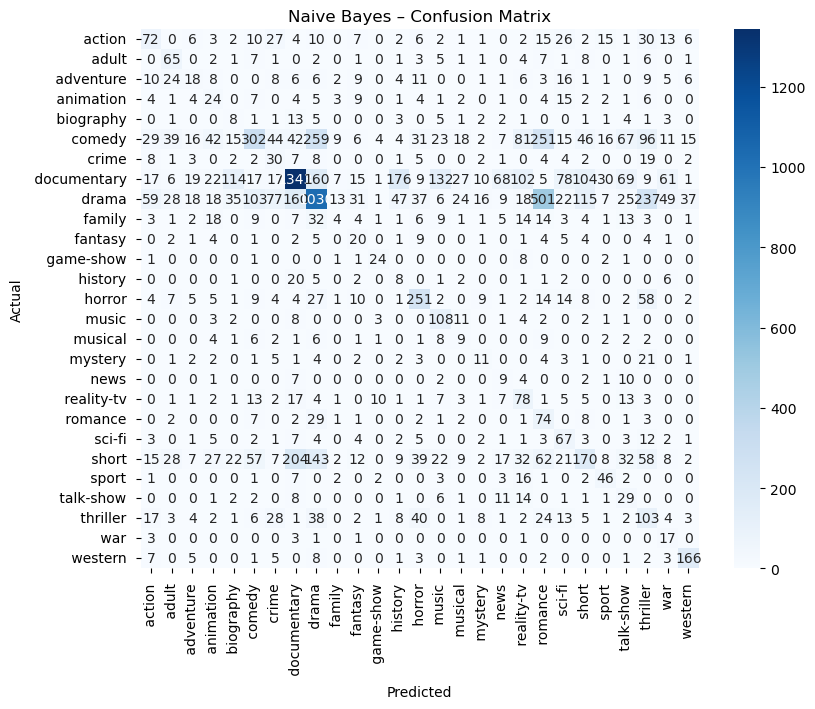

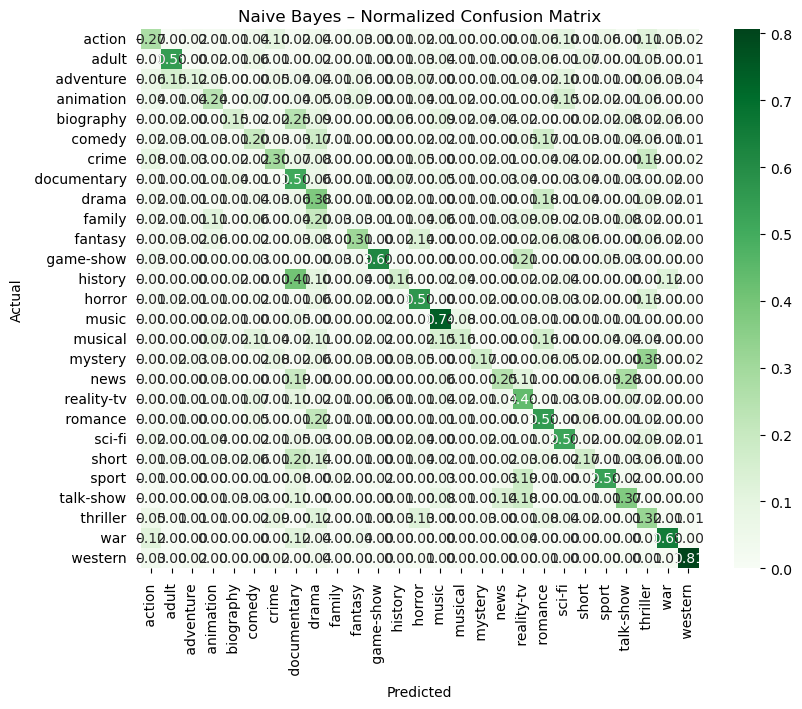


MODEL: Logistic Regression

▶ Accuracy: 0.5791

▶ Classification Report:
               precision    recall  f1-score   support

      action        0.43      0.33      0.37       263
       adult        0.57      0.37      0.45       118
   adventure        0.36      0.14      0.20       155
   animation        0.38      0.13      0.19       100
   biography        0.00      0.00      0.00        53
      comedy        0.52      0.56      0.54      1490
       crime        0.25      0.04      0.07       101
 documentary        0.68      0.84      0.75      2619
       drama        0.55      0.75      0.63      2723
      family        0.38      0.10      0.15       157
     fantasy        0.43      0.09      0.15        65
   game-show        0.81      0.56      0.67        39
     history        0.50      0.02      0.04        49
      horror        0.62      0.66      0.64       441
       music        0.59      0.52      0.55       146
     musical        0.60      0.05      0.10 

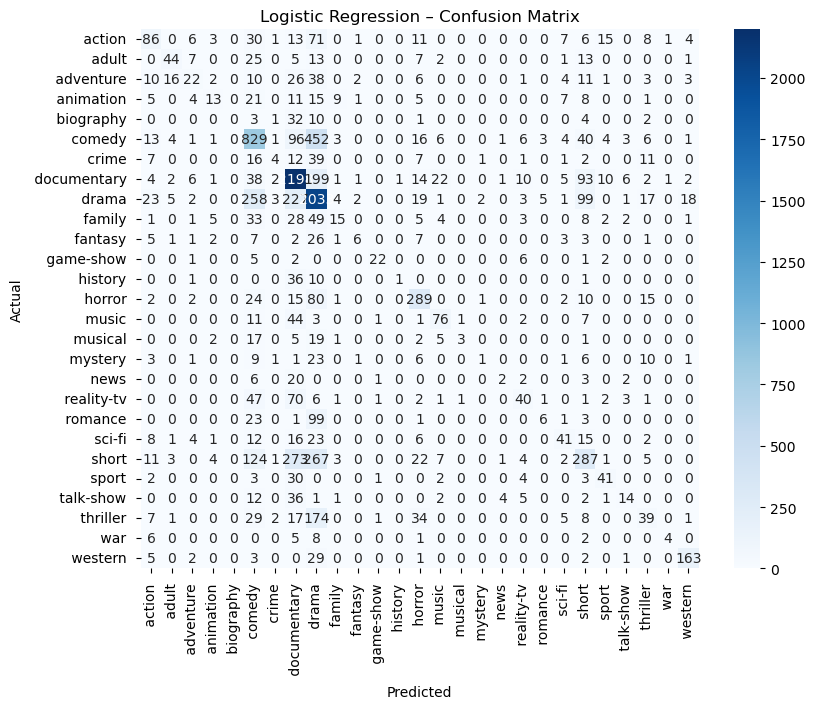

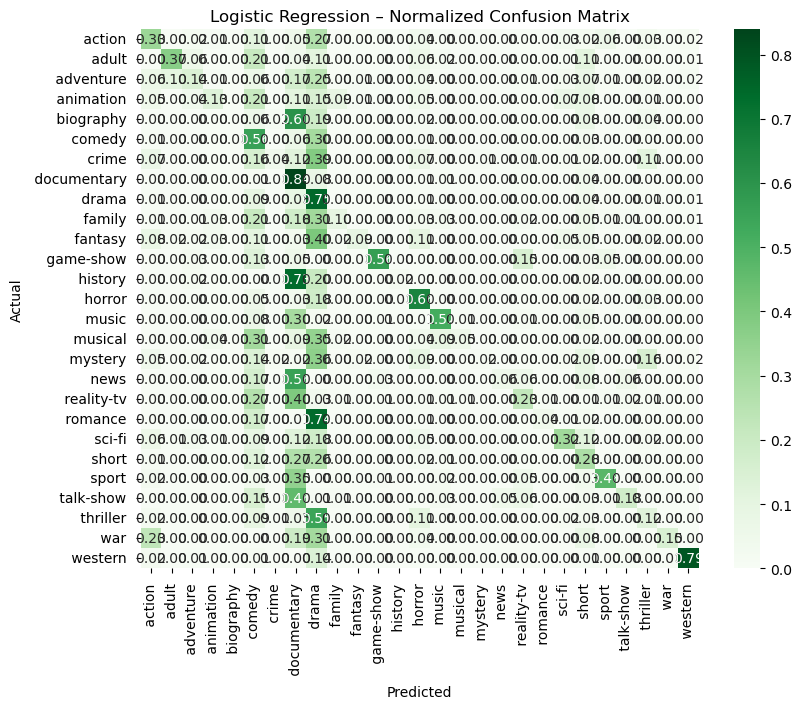


MODEL: Linear SVC

▶ Accuracy: 0.5732

▶ Classification Report:
               precision    recall  f1-score   support

      action        0.47      0.28      0.35       263
       adult        0.59      0.43      0.50       118
   adventure        0.44      0.07      0.12       155
   animation        0.41      0.09      0.15       100
   biography        0.00      0.00      0.00        53
      comedy        0.50      0.54      0.52      1490
       crime        0.00      0.00      0.00       101
 documentary        0.65      0.87      0.74      2619
       drama        0.54      0.76      0.64      2723
      family        0.54      0.04      0.08       157
     fantasy        1.00      0.02      0.03        65
   game-show        0.68      0.59      0.63        39
     history        0.00      0.00      0.00        49
      horror        0.58      0.66      0.62       441
       music        0.55      0.47      0.51       146
     musical        1.00      0.02      0.04        55

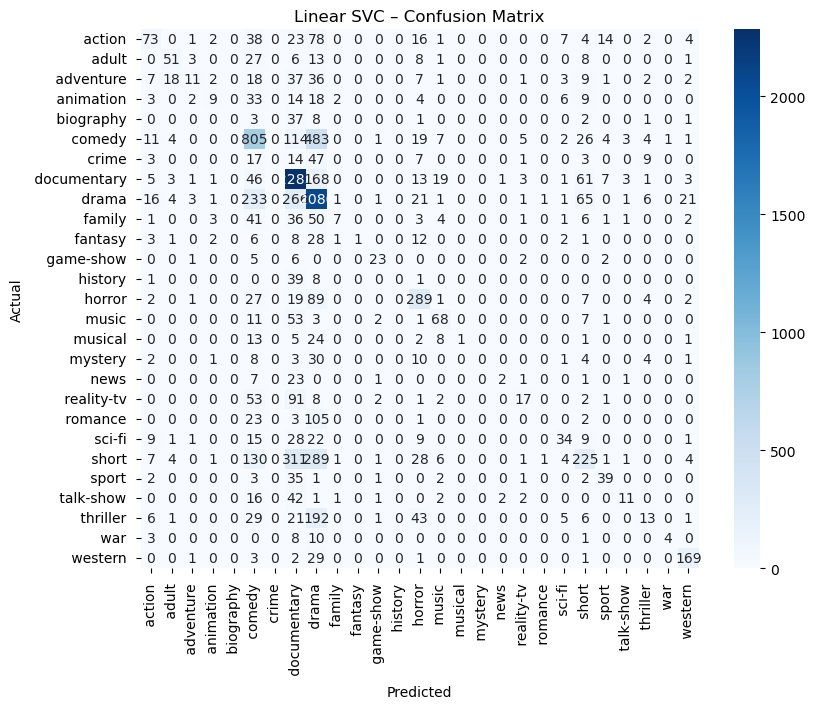

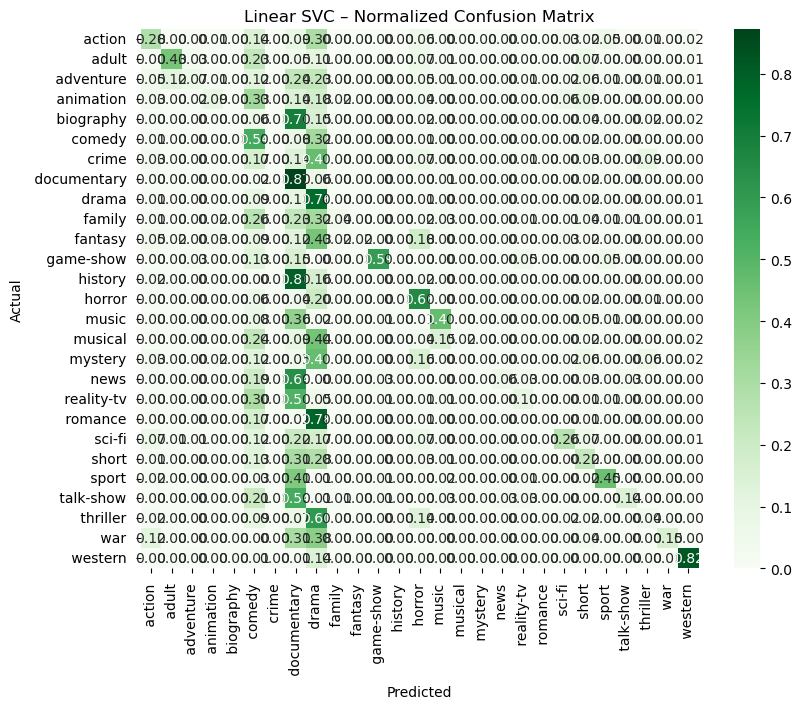



FINAL ACCURACY SUMMARY FOR ALL MODELS
Naive Bayes               : 0.3768
Logistic Regression       : 0.5791
Linear SVC                : 0.5732


In [62]:
# =============================================================
# EVALUATION FUNCTION FOR ALL MODELS (Accuracy + Reports + CM)
# =============================================================

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model_name, y_true, y_pred, label_encoder=None):
    """
    Prints accuracy, classification report, 
    and confusion matrices (raw + normalized)
    for any classifier.
    """

    print("\n" + "="*70)
    print(f"MODEL: {model_name}")
    print("="*70)

    # -------------------------
    # 1. ACCURACY
    # -------------------------
    acc = accuracy_score(y_true, y_pred)
    print(f"\n▶ Accuracy: {acc:.4f}")

    # -------------------------
    # 2. CLASSIFICATION REPORT
    # -------------------------
    print("\n▶ Classification Report:")
    if label_encoder:
        print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    else:
        print(classification_report(y_true, y_pred))

    # -------------------------
    # 3. CONFUSION MATRIX
    # -------------------------
    cm = confusion_matrix(y_true, y_pred)

    # RAW CONFUSION MATRIX
    plt.figure(figsize=(9,7))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=label_encoder.classes_ if label_encoder else None,
        yticklabels=label_encoder.classes_ if label_encoder else None
    )
    plt.title(f"{model_name} – Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # NORMALIZED CM
    cm_norm = confusion_matrix(y_true, y_pred, normalize="true")

    plt.figure(figsize=(9,7))
    sns.heatmap(
        cm_norm, annot=True, fmt=".2f", cmap="Greens",
        xticklabels=label_encoder.classes_ if label_encoder else None,
        yticklabels=label_encoder.classes_ if label_encoder else None
    )
    plt.title(f"{model_name} – Normalized Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return acc


# =============================================================
# EXAMPLE — AUTO-CHECK ALL MODELS
# =============================================================
# You must have these variables ready:
# y_val        = true labels (validation)
# le           = LabelEncoder
# pred_nb      = predictions from NB
# pred_lr      = predictions from Logistic Regression
# pred_svc     = predictions from SVC
# pred_w2v     = predictions from Word2Vec model
# pred_bert    = predictions from BERT model

models_dict = {
    "Naive Bayes": pred_nb,
    "Logistic Regression": pred_lr,
    "Linear SVC": pred_svc
}

results = {}

for model_name, predictions in models_dict.items():
    acc = evaluate_model(model_name, y_val, predictions, label_encoder=le)
    results[model_name] = acc

# =============================================================
# SUMMARY OF ALL ACCURACIES
# =============================================================
print("\n\n" + "="*70)
print("FINAL ACCURACY SUMMARY FOR ALL MODELS")
print("="*70)

for m, a in results.items():
    print(f"{m:25s} : {a:.4f}")
